I will pratice my pytorch skills in this notebook by writing an image classification alogrithm using Pytorch. This is based on the tutorial on this page: https://www.pluralsight.com/guides/image-classification-with-pytorch
The data could be downloaded from here: https://www.kaggle.com/c/aerial-cactus-identification/data
Please unzip the data to make the directory to have the following structure:
```
aerialcactus/
    train.csv
    sample_submission.csv
    train/
        train/
        *.jpg
    test/
        test/
            *.jpg
```

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [47]:
labels = pd.read_csv('../data/aerialcactus/train.csv')
submission = pd.read_csv('../data/aerialcactus/sample_submission.csv')
train_path = '../data/aerialcactus/train/train'
test_path = '../data/aerialcactus/test/test'

In [48]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [49]:
labels.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [50]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

([<matplotlib.patches.Wedge at 0x26164c42350>,
 [Text(-0.7762799652368623, 0.7793519202336362, 'Has Cactus'),
  Text(0.7762800017209579, -0.7793518838933475, "Hasn't Cactus")],
 [Text(-0.423425435583743, 0.42510104740016513, '24.9%'),
  Text(0.42342545548415883, -0.4251010275781895, '75.1%')])

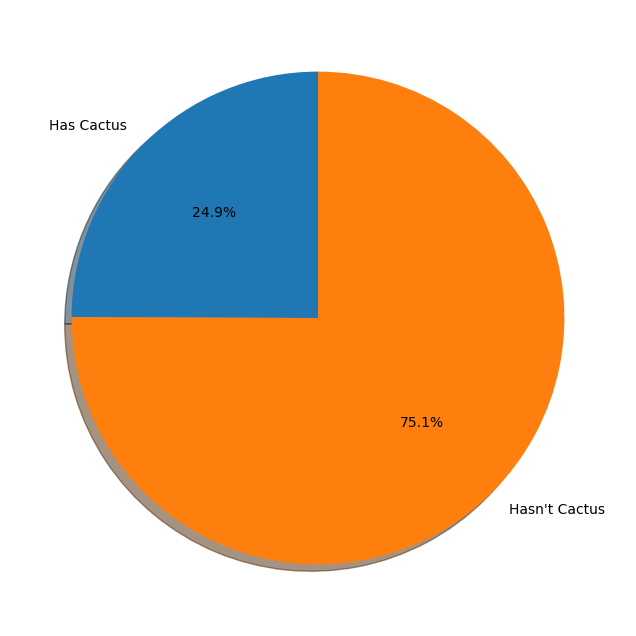

In [51]:
label = 'Has Cactus', 'Hasn\'t Cactus'
plt.figure(figsize=(8,8))
plt.pie(labels.groupby('has_cactus').size(), labels=label, autopct='%1.1f%%', shadow=True, startangle=90)

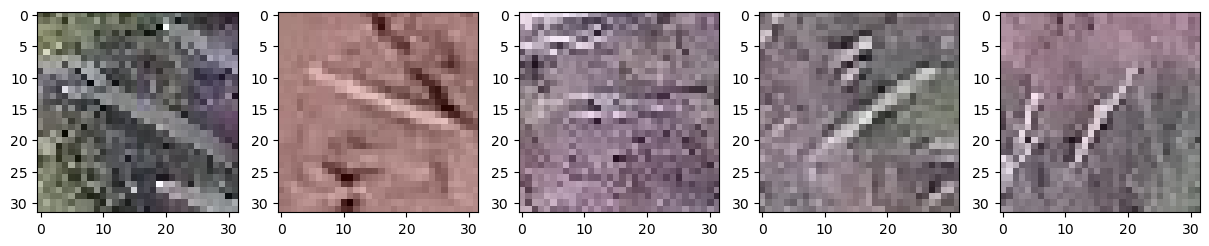

In [52]:
import matplotlib.image as img
import os

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for idx, filename in enumerate(labels[labels['has_cactus']==1]['id'][-5:]):
    path = os.path.join(train_path, filename)
    ax[idx].imshow(img.imread(path))

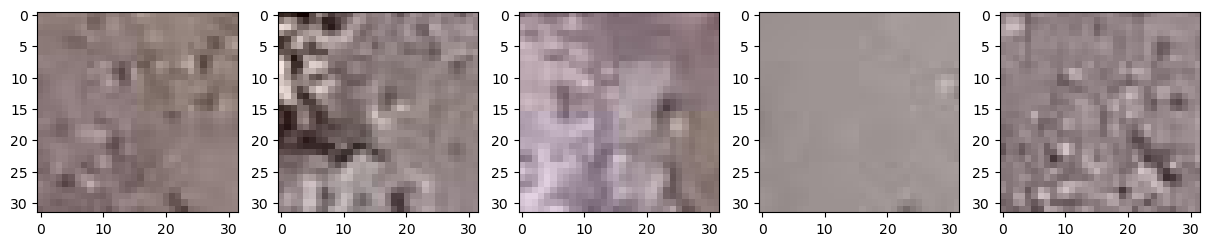

In [53]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for idx, filename in enumerate(labels[labels['has_cactus']==0]['id'][-5:]):
    path = os.path.join(train_path, filename)
    ax[idx].imshow(img.imread(path))

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# The mean and std are the mean and std from ImageNet which is widely used in computer vision tasks for normalizing images
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


def imshow(image, ax=None, title=None, normalize=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        image = std * image + mean  # convert the normalized images to the original image
        image = np.clip(image, 0, 1)  # avoid the overflow/underflow problems caused by numerical computation
    
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [55]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [56]:
train, valid_data = train_test_split(labels, stratify=labels.has_cactus, test_size=0.2)

In [57]:
class CactiDataset(Dataset):
    def __init__(self, data, path, transform=None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label


train_data = CactiDataset(train, train_path, train_transform)
valid_data = CactiDataset(valid_data, train_path, valid_transform)
test_data = CactiDataset(submission, test_path, test_transform)

In [58]:
num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.001
device = 'cuda'

In [59]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


training images
torch.Size([3, 32, 32])


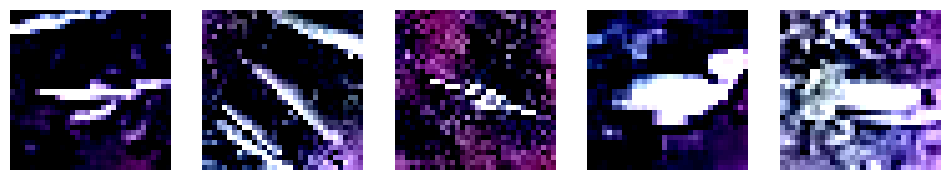

In [61]:
trainimages, trainlabels = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe = axes[i]
    imshow(trainimages[i], ax=axe, normalize=False)

print(trainimages[0].size())

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)   # 32x32x3 => 15x15x10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)                           # 15x15x10 => 6x6x20
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)                                         # 
        self.fc2 = nn.Linear(1024, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x)
        x = self.conv2(x)
        x = F.max_pool2d(x)
        x = x.view(x.shape[0], -1)
        x = F.relu
